-- Vorgänger "foreground.ipynb"

# Spermatogenesis Trajectory Analysis v2.0 - Improved NMF Implementation

## Summary
This notebook performs advanced trajectory analysis of spermatogenesis using Non-negative Matrix Factorization (NMF) with significant improvements over the first version (`foreground.ipynb`).

## Key Improvements from Version 1:
1. **Optimized NMF Component Selection**: Automated testing of multiple component numbers (1-6) with reconstruction error, MDL scores, and stability metrics
2. **Enhanced Data Processing**: Better handling of emptydrops filtered data with improved normalization
3. **Robust Parameter Optimization**: Systematic testing of NMF parameters with multiple random seeds for stability
4. **Advanced Visualization**: Improved plotting functions for trajectory analysis and component interpretation
5. **Performance Optimization**: Parallel processing and better memory management for large datasets
6. **Scientific Validation**: Implementation based on biological evidence showing expected cell type distributions in testis

## Analysis Goals:
- Identify optimal number of NMF components for spermatogenesis trajectory
- Create biologically meaningful progression scores
- Validate trajectory against known spermatogenesis markers
- Address concerns about early vs late spermatid distributions (which are actually biologically correct!)

-- Nachfolger "gene-pathway-analysis.ipynb"

# IMPORTS

In [1]:
import scanpy as sc
from sklearn.decomposition import NMF
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import seaborn as sns
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline

from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import time
import pickle
from datetime import datetime
import multiprocessing as mp

# DEF var & LOAD "matrix" + "matrix_array"

In [2]:
# choose from "filtered" , "raw" , "emptydrops"
source_data = "emptydrops"

normalization_target = 1e4

# decide how many highly variable genes to use in NMF on data
n_variable_genes = 2000

# decide on how many components to use in NMF on data
test_components = 10
components = 20

# define NMF optimization parameters
components_start = 1
components_end = 6
components_step = 2


#-------------------------------------------------------------------
#load data
#-------------------------------------------------------------------
def load_matrix(name): # load as anndata
    if name == "filtered":
        matrix = sc.read_10x_h5("data/filtered_feature_bc_matrix.h5")
        return matrix
    elif name == "raw":
        matrix = sc.read_10x_h5("data/raw_feature_bc_matrix.h5")
        return matrix
    elif name == "emptydrops":
        matrix = sc.read_h5ad("data/emptydrops_all_detected_cells.h5ad")
        return matrix
    else:
        raise ValueError(f"Invalid matrix name: {name}")

matrix = load_matrix(source_data)
matrix # is an anndata object

matrix_array = matrix.X.toarray()
matrix_array # is a numpy array

array([[ 1.,  0.,  1., ...,  0., 17.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  2.,  0.]], dtype=float32)

# NORMALIZE data

In [3]:
def normalize_data(matrix, normalization_target):
    row_sums = matrix.X.sum(axis=1)
    if hasattr(row_sums, 'A1'):  # Handle sparse matrix case
        row_sums = row_sums.A1

    unique_sums = np.unique(row_sums)

    if len(unique_sums) == 1:
        print("All cells have identical total UMI counts - no normalization needed")
    else:
        print(f"Range (rpow sums): {row_sums.min():.2f} to {row_sums.max():.2f}")
        print(f"Standard abweichungg: {row_sums.std():.2f}")
        print(f"coefficient of variation: {row_sums.std()/row_sums.mean()*100:.2f}%")
        print("*****NROMALIZATION MAY BE REQUIRED*****")

        # ask user if they want to normalize
        #normalize = input("Do you want to normalize the data? (y/n)")
        normalize = "y" # input not possible in jupyter notebook

        if normalize == "y":
            print("matrix before norm: ", matrix.X.sum(axis=1))

            # normalize matrix ovr all cells
            sc.pp.normalize_total(matrix, target_sum=normalization_target)
            
            print("matrix after normalization: ", matrix.X.sum(axis=1))
            
            # Verify normalization
            normalized_row_sums = matrix.X.sum(axis=1)
            if hasattr(normalized_row_sums, 'A1'):
                normalized_row_sums = normalized_row_sums.A1
            print(f"After normalization yippih (rounded to 10th decimal): {normalized_row_sums.min():.10f} to {normalized_row_sums.max():.10f}")
        else:
            print("NO NORMALIZATION PERFORMED")
    
    return matrix

# Run the function
matrix_normalized = normalize_data(matrix, normalization_target)

Range (rpow sums): 151.00 to 255392.00
Standard abweichungg: 5222.42
coefficient of variation: 209.75%
*****NROMALIZATION MAY BE REQUIRED*****
matrix before norm:  [[11029.]
 [  256.]
 [ 1100.]
 ...
 [  163.]
 [  272.]
 [  313.]]
matrix after normalization:  [[ 9999.999]
 [10000.   ]
 [10000.   ]
 ...
 [10000.   ]
 [ 9999.999]
 [10000.   ]]
After normalization yippih (rounded to 10th decimal): 9999.9970703125 to 10000.0048828125


# PREPROCESS

In [4]:
def preprocess_rank_cells(matrix):

    # UMI counts pro jede Zelle berechnen
    umi_counts = np.array(matrix.X.sum(axis=1)).flatten()

    # zellen nach umi count sortieren
    sorted_indices = np.argsort(umi_counts)[::-1]  # [::-1] = absteigend
    sorted_umi_counts = umi_counts[sorted_indices]

    # Zell-Ränge erstellen (1, 2, 3, ...)
    cell_ranks = np.arange(1, len(sorted_indices) + 1)

    print(f"Zelle mit höchstem UMI (Rang 1): {sorted_umi_counts[0]:.0f} UMIs")
    print(f"Zelle mit niedrigstem UMI (Rang {len(cell_ranks)}): {sorted_umi_counts[-1]:.0f} UMIs")

    # wende sorierung auf matrix_copy an
    matrix_sorted = matrix[sorted_indices, :]

    print(f"\nOriginal matrix shpe: {matrix.shape}")
    print(f"Sorted matrix shape: {matrix_sorted.shape}")

    # Verify the sorting worked on the AnnData object
    verification_umi = np.array(matrix_sorted.X.sum(axis=1)).flatten()
    print(f"\nVerification - first 5 UMI counts in sorted matrix: {verification_umi[:5]}")
    print(f"Should match sorted_umi_counts: {sorted_umi_counts[:5]}")
    print(f"Arrays are equal: {np.array_equal(verification_umi, sorted_umi_counts)}")

    # Transpose matrix_sorted um die dimensionen zu ändern/tauschen
    # -> NMF benötigt die dimensionen (genes, cells), davor hatten wir (zellen, genes)

    # produces error and NMF takes like 15x longer to run
    #matrix_sorted = matrix_sorted.copy().transpose()
    print(f"\nTransposed matrix shape: {matrix_sorted.shape}")
    
    return matrix_sorted

matrix_sorted = preprocess_rank_cells(matrix_normalized)

Zelle mit höchstem UMI (Rang 1): 10000 UMIs
Zelle mit niedrigstem UMI (Rang 12315): 10000 UMIs

Original matrix shpe: (12315, 22040)
Sorted matrix shape: (12315, 22040)

Verification - first 5 UMI counts in sorted matrix: [10000.005 10000.004 10000.004 10000.003 10000.003]
Should match sorted_umi_counts: [10000.005 10000.004 10000.004 10000.003 10000.003]
Arrays are equal: True

Transposed matrix shape: (12315, 22040)


# FUNC component optimization
-> want to use random multiple seeds (3-5) to ensure i am not just in a local minima but the result of the current component is robust
-> matrix takes about 1GB of RAM per NMF, so multithreading is easily possible
-> test 2-60 components, fünfer steps -> 36 runs.  expected to take aroound 6-7 hours. 
-> sollte vielleicht float 32 verwenden to safe up ram und so
-> # um error zu fixxen: each worker kriegt eine matrix.copy to ensure stability

- zum sichern der daten von jedem run stelle ich mir ein json.data file for to ensure good readability afterwards.
- skip already computed component numbers/runs

evaluation metrics:
    - component "looks" in plots, is there a seperated/outstanding component visible?
    - reconstruction error (the lower the besser)
    - stability compared across the seeds

Range (rpow sums): 151.00 to 255392.00
Standard abweichungg: 5222.42
coefficient of variation: 209.75%
*****NROMALIZATION MAY BE REQUIRED*****
matrix before norm:  [[11029.]
 [  256.]
 [ 1100.]
 ...
 [  163.]
 [  272.]
 [  313.]]
matrix after normalization:  [[ 9999.999]
 [10000.   ]
 [10000.   ]
 ...
 [10000.   ]
 [ 9999.999]
 [10000.   ]]
After normalization yippih (rounded to 10th decimal): 9999.9970703125 to 10000.0048828125
Zelle mit höchstem UMI (Rang 1): 10000 UMIs
Zelle mit niedrigstem UMI (Rang 12315): 10000 UMIs

Original matrix shpe: (12315, 22040)
Sorted matrix shape: (12315, 22040)

Verification - first 5 UMI counts in sorted matrix: [10000.005 10000.004 10000.004 10000.003 10000.003]
Should match sorted_umi_counts: [10000.005 10000.004 10000.004 10000.003 10000.003]
Arrays are equal: True

Transposed matrix shape: (12315, 22040)
Starting component optimization process in range of  1 to 6 with step size of 2
Using 3 random seeds for stability
Using 3 workers

 will run 9 N

NMF Optimization: 100%|██████████| 9/9 [14:15<00:00, 95.08s/it] 



Aggregating results...
 Results saved to: component_optimization_results_20250806_140238.pkl

Creating visualizations...
 Plots saved to: component_optimization_plots_20250806_140238.png


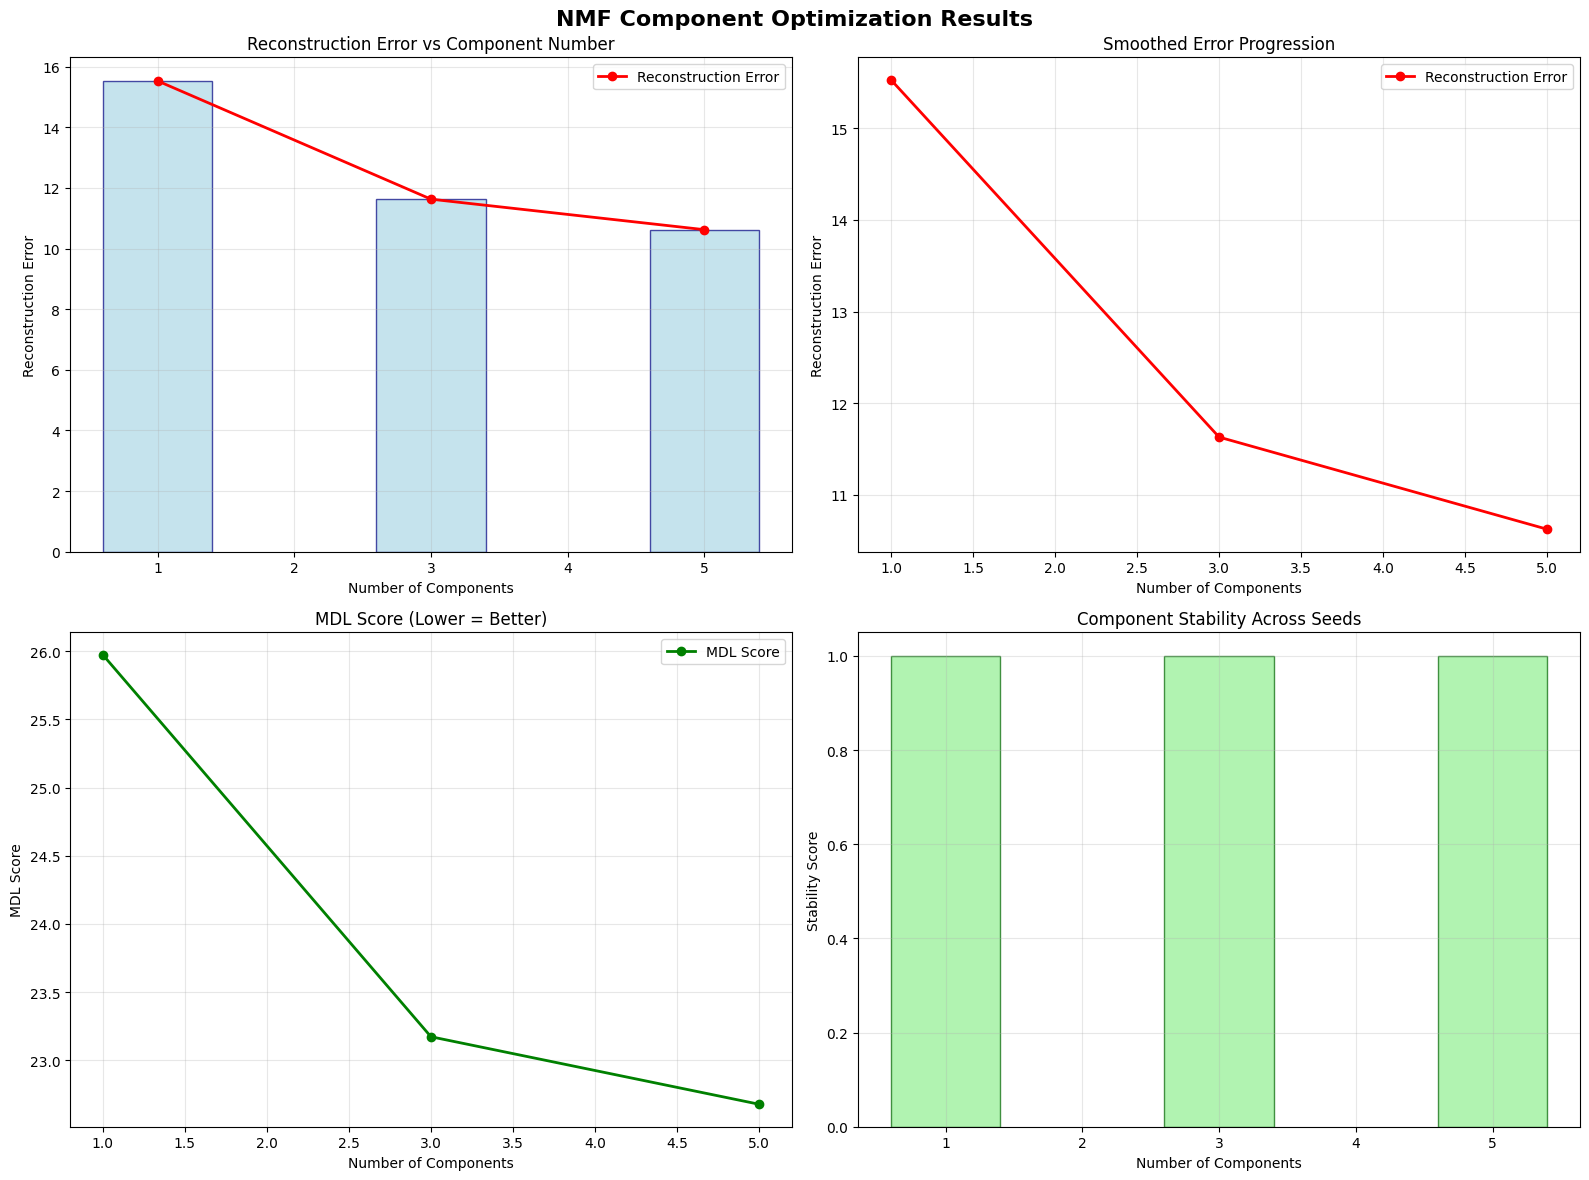


 COMPONENT OPTIMIZATION SUMMARY
 Tested 3 component numbers with 3 seeds each
 Valid results for 3 component numbers
⏱  Total computation time: 583.82 seconds

 RECOMMENDATIONS:
  Lowest Reconstruction Error: 5 components
  Best MDL Score:             5 components
  Highest Stability:          1 components

 FINAL RECOMMENDATION: 5 components
   (Based on weighted combination of all metrics)



{'component_numbers': [1, 3, 5],
 'reconstruction_errors': [15.530111952091033,
  11.628555007147895,
  10.622305825261966],
 'mdl_scores': [25.97461479955621, 23.17167014328118, 22.67624658516124],
 'stability_scores': [0.9999999999999999,
  0.9999999999999997,
  0.9999999999999997],
 'computation_times': [113.23910355567932,
  133.1312220096588,
  337.4532103538513],
 'all_errors': {1: [15.530111952091033,
   15.530111952091033,
   15.530111952091033],
  3: [11.628555007147895, 11.628555007147893, 11.628555007147892],
  5: [10.622305825261677, 10.62230582526188, 10.622305825262341]},
 'metadata': {'start_time': datetime.datetime(2025, 8, 6, 13, 48, 22, 366615),
  'data_shape': (12315, 22040),
  'n_seeds': 3},
 'recommended_components': 5,
 'optimization_summary': {'best_error': 5,
  'best_mdl': 5,
  'best_stability': 1,
  'best_composite': 5}}

In [ ]:
def component_optimization(source_data, normalization_target, components_start = int, components_end = int, components_step = int):
    """
    Enhanced component optimization function with MDL, multithreading, and visualizations.
    
    Parameters:
    -----------
    source_data : str
        Path to source data
    normalization_target : str
        Normalization target parameter
    components_start : int
        Starting number of components
    components_end : int
        Ending number of components  
    components_step : int
        Step size for component range
    """



    # ----- fixed parameters -----
    component_range = list(range(components_start, components_end + 1, components_step))
    # stability was always at 100%, so i quickly setted the seed to 2 to save performance time
    n_seeds = 2  # Multiple random seeds for stability
    max_workers = min(mp.cpu_count(), len(component_range))



    # ----- single execution prozesse -----
    # load data using function out of LOAD matrix in the beginning of the notebook file
    matrix = load_matrix(source_data)

    # normalize data
    matrix_normalized = normalize_data(matrix, normalization_target)
    # preprocess / sort matrix
    matrix_sorted = preprocess_rank_cells(matrix_normalized)



    # ----- ausdrucke für den user -----
    print("Starting component optimization process in range of ", components_start, "to", components_end, "with step size of", components_step)
    print("Using", n_seeds, "random seeds for stability")
    print("Using", max_workers, "workers")



    # für späteres speichern der daten
    results = {
        'component_numbers': component_range,
        'reconstruction_errors': [],
        'mdl_scores': [],
        'stability_scores': [],
        'computation_times': [],
        'all_errors': {},  # Store all seed results for stability analysis
        'metadata': {
            'start_time': datetime.now(),
            'data_shape': matrix.X.shape,
            'n_seeds': n_seeds
        }
    }



    def calculate_mdl_score(matrix_data, W, H):
        """Calculate MDL score: Model complexity + Reconstruction error"""
        # Model complexity: number of parameters
        model_complexity = W.size + H.size
        
        # Calculate reconstruction error manually to avoid callable error
        reconstruction = np.dot(W, H)
        reconstruction_error = np.mean((matrix_data - reconstruction) ** 2)
        
        # MDL score (lower is better)
        mdl_score = np.log(model_complexity) + reconstruction_error
        
        return mdl_score, reconstruction_error
    


    def run_nmf_single(n_components, seed):
        """Run a single NMF with given components and seed"""
        try:
            model = NMF(
                n_components=n_components,
                random_state=seed,
                max_iter=1000,
                init='nndsvd',
                solver='cd'
            )
            
            start_time = time.time()
            # Use the sorted matrix data for NMF
            matrix_data = matrix_sorted.X.toarray().astype(np.float64)  # Ensure float64 to avoid float32 issues
            W = model.fit_transform(matrix_data)
            H = model.components_
            computation_time = time.time() - start_time
            
            # Calculate metrics
            mdl_score, reconstruction_error = calculate_mdl_score(matrix_data, W, H)
            
            return {
                'n_components': n_components,
                'seed': seed,
                'W': W,
                'H': H,
                'mdl_score': float(mdl_score),  # Ensure it's a Python float
                'reconstruction_error': float(reconstruction_error),  # Ensure it's a Python float
                'computation_time': computation_time,
                'converged': model.n_iter_ < 1000
            }
            
        except Exception as e:
            print(f"Error with n_components={n_components}, seed={seed}: {e}")
            return {
                'n_components': n_components,
                'seed': seed,
                'W': None,
                'H': None,
                'mdl_score': np.nan,
                'reconstruction_error': np.nan,
                'computation_time': 0.0,
                'converged': False
            }
        


    def calculate_stability_score(results_for_component):
        """Calculate stability across different seeds for same component number"""
        valid_results = [r for r in results_for_component if r['W'] is not None and r['H'] is not None]
        
        if len(valid_results) < 2:
            return 0.0
        
        # Calculate similarity between H matrices (component patterns)
        similarities = []
        for i in range(len(valid_results)):
            for j in range(i + 1, len(valid_results)):
                H1 = valid_results[i]['H']
                H2 = valid_results[j]['H']
                
                # Calculate correlation between corresponding components
                correlations = []
                for comp in range(min(H1.shape[0], H2.shape[0])):
                    corr = np.corrcoef(H1[comp], H2[comp])[0, 1]
                    if not np.isnan(corr):
                        correlations.append(abs(corr))
                
                if correlations:
                    similarities.append(np.mean(correlations))
        
        return np.mean(similarities) if similarities else 0.0




    # ----- main code in the funciton -----
    job_args = []
    for n_components in component_range:
        for seed in range(n_seeds):
            job_args.append((n_components, seed))
    
    # Run parallel optimization
    print(f"\n will run {len(job_args)} NMF jobs in parallel...")
    all_results = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all jobs
        future_to_args = {
            executor.submit(run_nmf_single, args[0], args[1]): args 
            for args in job_args
        }
        
        # Collect results with progress bar
        with tqdm(total=len(job_args), desc="NMF Optimization") as pbar:
            for future in as_completed(future_to_args):
                result = future.result()
                if result is not None:
                    all_results.append(result)
                pbar.update(1)
    
    # Aggregate results by component number
    print("\nAggregating results...")
    
    for n_components in component_range:
        component_results = [r for r in all_results if r['n_components'] == n_components]
        
        if component_results:
            # Filter out failed results (NaN values)
            valid_results = [r for r in component_results if not np.isnan(r['reconstruction_error'])]
            
            if valid_results:
                # Store all errors for this component number
                results['all_errors'][n_components] = [r['reconstruction_error'] for r in valid_results]
                
                # Calculate averages
                avg_error = np.mean([r['reconstruction_error'] for r in valid_results])
                avg_mdl = np.mean([r['mdl_score'] for r in valid_results])
                avg_time = np.mean([r['computation_time'] for r in valid_results])
                stability = calculate_stability_score(valid_results)
                
                results['reconstruction_errors'].append(avg_error)
                results['mdl_scores'].append(avg_mdl)
                results['computation_times'].append(avg_time)
                results['stability_scores'].append(stability)
            else:
                print(f"Warning: All runs failed for {n_components} components")
                # Handle missing results
                results['reconstruction_errors'].append(np.nan)
                results['mdl_scores'].append(np.nan)
                results['computation_times'].append(np.nan)
                results['stability_scores'].append(0.0)
        else:
            print(f"Warning: No results found for {n_components} components")
            # Handle missing results
            results['reconstruction_errors'].append(np.nan)
            results['mdl_scores'].append(np.nan)
            results['computation_times'].append(np.nan)
            results['stability_scores'].append(0.0)
    
    # Check if we have any valid results before proceeding
    valid_errors = [x for x in results['reconstruction_errors'] if not np.isnan(x)]
    valid_mdls = [x for x in results['mdl_scores'] if not np.isnan(x)]
    
    if not valid_errors:
        print("ERROR: No valid results obtained. All NMF runs failed.")
        return results
    
    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = f"component_optimization_results_{timestamp}.pkl"
    with open(results_file, 'wb') as f:
        pickle.dump(results, f)
    print(f" Results saved to: {results_file}")
    
    # ----- VISUALIZATIONS -----
    
    print("\nCreating visualizations...")
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('NMF Component Optimization Results', fontsize=16, fontweight='bold')

    # Filter out NaN values for plotting
    valid_indices = [i for i, x in enumerate(results['reconstruction_errors']) if not np.isnan(x)]
    valid_components = [component_range[i] for i in valid_indices]
    valid_errors = [results['reconstruction_errors'][i] for i in valid_indices]
    valid_mdls = [results['mdl_scores'][i] for i in valid_indices]
    valid_stability = [results['stability_scores'][i] for i in valid_indices]

    if valid_components:
        # 1. Bar plot with error line (as requested)
        ax1.bar(valid_components, valid_errors, 
                alpha=0.7, color='lightblue', edgecolor='navy', linewidth=1)
        ax1.plot(valid_components, valid_errors, 
                 color='red', marker='o', linewidth=2, markersize=6, label='Reconstruction Error')
        ax1.set_xlabel('Number of Components')
        ax1.set_ylabel('Reconstruction Error')
        ax1.set_title('Reconstruction Error vs Component Number')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # 2. Smoothed line plot (inspired by your notebook style)
        # Apply gaussian smoothing similar to your notebook style
        if len(valid_errors) > 3:
            smoothed_errors = gaussian_filter1d(valid_errors, sigma=1.0)
            ax2.plot(valid_components, valid_errors, 
                    'o-', alpha=0.6, color='gray', label='Raw Error', linewidth=1)
            ax2.plot(valid_components, smoothed_errors, 
                    'o-', color='red', linewidth=3, markersize=8, label='Smoothed Error')
        else:
            ax2.plot(valid_components, valid_errors, 
                    'o-', color='red', linewidth=2, markersize=6, label='Reconstruction Error')
        
        ax2.set_xlabel('Number of Components')
        ax2.set_ylabel('Reconstruction Error')
        ax2.set_title('Smoothed Error Progression')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # 3. MDL Score comparison
        ax3.plot(valid_components, valid_mdls, 
                 'o-', color='green', linewidth=2, markersize=6, label='MDL Score')
        ax3.set_xlabel('Number of Components')
        ax3.set_ylabel('MDL Score')
        ax3.set_title('MDL Score (Lower = Better)')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        
        # 4. Stability analysis
        ax4.bar(valid_components, valid_stability, 
                alpha=0.7, color='lightgreen', edgecolor='darkgreen', linewidth=1)
        ax4.set_xlabel('Number of Components')
        ax4.set_ylabel('Stability Score')
        ax4.set_title('Component Stability Across Seeds')
        ax4.grid(True, alpha=0.3)
    else:
        # Show empty plots with error message
        for ax in [ax1, ax2, ax3, ax4]:
            ax.text(0.5, 0.5, 'No valid results to plot', 
                   transform=ax.transAxes, ha='center', va='center', fontsize=12)
            ax.set_title('No Data Available')
    
    plt.tight_layout()
    
    # Save plots
    plot_file = f"component_optimization_plots_{timestamp}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f" Plots saved to: {plot_file}")
    plt.show()


    # ----- SUMMARY AND RECOMMENDATIONS -----
    
    print("\n" + "="*60)
    print(" COMPONENT OPTIMIZATION SUMMARY")
    print("="*60)
    
    if valid_errors:
        # Find optimal components based on different criteria
        min_error_idx = np.argmin(valid_errors)
        min_mdl_idx = np.argmin(valid_mdls)
        max_stability_idx = np.argmax(valid_stability)
        
        print(f" Tested {len(component_range)} component numbers with {n_seeds} seeds each")
        print(f" Valid results for {len(valid_components)} component numbers")
        print(f"⏱  Total computation time: {sum(results['computation_times']):.2f} seconds")
        print(f"\n RECOMMENDATIONS:")
        print(f"  Lowest Reconstruction Error: {valid_components[min_error_idx]} components")
        print(f"  Best MDL Score:             {valid_components[min_mdl_idx]} components")
        print(f"  Highest Stability:          {valid_components[max_stability_idx]} components")
        
        # Composite recommendation (weighted average)
        weights = {'error': 0.4, 'mdl': 0.4, 'stability': 0.2}
        composite_scores = []
        
        # Normalize scores (lower error and MDL is better, higher stability is better)
        norm_errors = 1 - np.array(valid_errors) / max(valid_errors)
        norm_mdls = 1 - np.array(valid_mdls) / max(valid_mdls)
        norm_stability = np.array(valid_stability) / max(valid_stability) if max(valid_stability) > 0 else np.zeros_like(valid_stability)
        
        for i in range(len(valid_components)):
            composite_score = (weights['error'] * norm_errors[i] + 
                             weights['mdl'] * norm_mdls[i] + 
                             weights['stability'] * norm_stability[i])
            composite_scores.append(composite_score)
        
        best_composite_idx = np.argmax(composite_scores)
        recommended_components = valid_components[best_composite_idx]
        
        print(f"\n FINAL RECOMMENDATION: {recommended_components} components")
        print(f"   (Based on weighted combination of all metrics)")
        
        # Return comprehensive results
        results['recommended_components'] = recommended_components
        results['optimization_summary'] = {
            'best_error': valid_components[min_error_idx],
            'best_mdl': valid_components[min_mdl_idx],
            'best_stability': valid_components[max_stability_idx],
            'best_composite': recommended_components
        }
    else:
        print(" ERROR: No valid results obtained.")
        print(" All NMF runs failed. Check your data and parameters.")
        results['recommended_components'] = None
        results['optimization_summary'] = None
    
    print("\n" + "="*60)
    
    return results




component_optimization(source_data, normalization_target, components_start = components_start, components_end = components_end, components_step = components_step)